# Binary_classification _Insuarance_Claim_Status_Case_study

**Table Of Contents:**

    * Introduction
    * Abstract
    * Libraries
    * Get Data
    * Data Pre Processing
    * Exploratory data analysis
    * Make Prediction
    * Evaluate Prediction
    * Summary

# Introduction

A third-party travel insurance servicing company that is based in Singapore. <br>
The Company wants to know if Insurance claim will be accept or not accept. <br>
more info: https://www.kaggle.com/mhdzahier/travel-insurance

# Abstract

Imbalance Target ~1.5% - Yes , ~98.5%- No . <br>
Not allow us to learn anything significant. <br>
My recommendation is to add more observations and/or add more attributes to explore.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, QuantileTransformer, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', -1) 
sns.set_style("whitegrid")

C:\Users\Home\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Get Data

In [4]:
df = pd.read_csv(r'C:\\Users\Home\Documents\idan\Kaggle\Binary_classification\Insuarance_claim\Dataset\travel insurance.csv')
display(df.shape)
df.head()

(63326, 11)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


**Split to Train Test**

Explain: We split to train and test for preventring  data leakage

In [2574]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = 'Claim')
y = df.Claim
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30, random_state=None)

train = pd.concat([X_train,y_train],axis=1)
test = pd.concat([X_test,y_test],axis=1)

df = train.copy()
print('train',df.shape)
print('test',test.shape)

train (31029, 11)
test (13299, 11)


# Data Pre Processing

* **Fit Attributes according Kaggle txt file attached**
* **Data Cleaning**
* **Impute Missing values**

### Fit Attributes according Kaggle txt file attached

In [2575]:
df.dtypes

Agency                  object 
Agency Type             object 
Distribution Channel    object 
Product Name            object 
Duration                int64  
Destination             object 
Net Sales               float64
Commision (in value)    float64
Gender                  object 
Age                     int64  
Claim                   object 
dtype: object

***Explain: All Data Types are correct***

### Data Cleaning

  * Remove Duplicates
  * Remove unrelevant columns
  * View Missing Values
  * Treat Missing values
  * Impute 

**Remove Duplicates**

In [2576]:
total_duplicates = len(df) - len(df.drop_duplicates())
duplicate_percent =  total_duplicates/len(df)*100
if total_duplicates > 0 :
   print(f'\n\n ** total duplicates {total_duplicates} removed, %.0f%% ** \n\n' %(duplicate_percent), end= '\n')
   df.drop_duplicates(inplace=True)
else :
   print('\n\n ** No Duplicates ** \n\n')



 ** total duplicates 2562 removed, 8% ** 




**Remove unrelevant columns**

In [2577]:
print('\n\n **No columns to drop** \n\n')



 **No columns to drop** 




**Treat Missing values**

 * View Missing values
 * **Rows** contain more than 50% missing values will be removed
 * **Rows** with missing target price will be removed
 * **Attributes** contain more than 99% missing values will be removed - **not relevant**
 * **Attributes** contain  80%-99% missing values will transform to binary features - **not relevant**
 * **Attributes** contain  5%-80% missing values will transform to 'unknown' - category / 0 - numerical
 * **Attributes** contain 0% -5% missing values will impute - **not relevant**

* **View Missing Values**

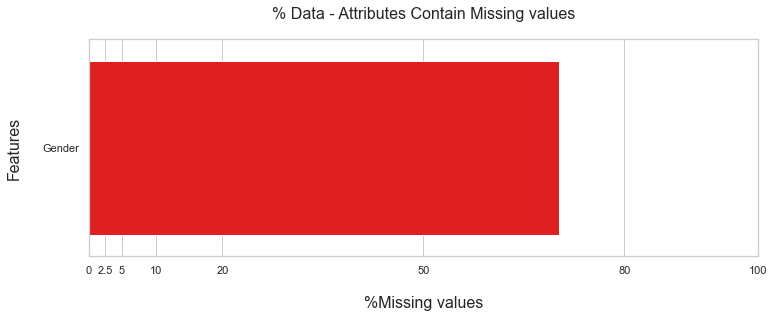

In [2578]:
if sum(df.isnull().sum()) > 0 : 
    
   # view chart of columns with missing values
   missing_values_per_column = df.isnull().sum()
   missing_values_per_column_InPercentage =  round((missing_values_per_column.loc[missing_values_per_column>0]/len(df))*100,4)
   missing_values_columns_table =  pd.DataFrame(missing_values_per_column_InPercentage.sort_values(ascending=False)).reset_index().rename(columns={'index':'features',0:'%Percentage'})
   plt.figure(figsize = (12,4))
   sns.barplot(x = '%Percentage',y= 'features', data = missing_values_columns_table, orient = 'h',color='red')
   plt.title('% Data - Attributes Contain Missing values',size=16, pad = 20 )
   plt.ylabel("Features", size=16, labelpad = 20)
   plt.xlabel("%Missing values", size=16, labelpad = 20)
   labels = (0,2.5,5,10,20,50,80,100)
   plt.xticks([0,2.5,5,10,20,50,80,100], labels)
   plt.show()
    
else:
    print('No Missing Values', end ='\n')

***Explain: 'Gender' attribute contain 70% missing values.
             Therefore, missing values should transform to 'unknown'.***

* **Rows** contain more than 50% missing values will be removed

In [2579]:
# train
if sum(df.isnull().sum()) > 0 :    
   #remove rows with more than 50% missing values
   total_rows_to_drop  = len(df) - len(df.dropna(axis= 'index',thresh = int(len(df.columns)*0.5),inplace=False))
   df.dropna(axis= 'index',thresh = int(len(df.columns)*0.5),inplace=True)
   print(f'\n\n** Removed total {total_rows_to_drop} rows **\n\n')
else:
    print('\n\nNo Rows to drop\n\n', end ='\n')



** Removed total 0 rows **




 * **Rows** with missing target price will be removed

In [2580]:
# train
if sum(df.isnull().sum()) > 0 : 
   #remove all blank rows in target column
   total_rows_in_target = len(df) -  len(df.dropna(how='any',subset = ['Claim'],inplace=False))
   if  total_rows_in_target > 0 :
      df.dropna(how='any',subset = ['Claim'],inplace=True)
      print(f'\n\n** Removed  {total_rows_in_target} rows  with missing target value **\n\n')
   else:
      print('\n\n** No Missing values in Target column **\n\n', end ='\n')



** No Missing values in Target column **




* **Attributes** contain  5%-80% missing values will transform to 'unknown' - category

In [2581]:
print('\n\n')
for index, column in enumerate (missing_values_columns_table.loc[missing_values_columns_table['%Percentage'].between(5, 79.999, inclusive = True)==True,'features' ]):
    if df[column].dtype == 'object' :
        df[column] = df[column].fillna('unknown')
        print(f'** {column} column added "unknown" category **')
    else :
        df[column] = df[column].fillna(0)
        print(f'** {column} column add "0" category **')


# test
test['Gender'] = test['Gender'].fillna('unknown')




** Gender column added "unknown" category **


# Exploratory data analysis

Table of contents:

  * Split train into groups: categorical, numerical
  * Show Attributes Distribution
  * Correlation with target
  * Feature Engineering
  * Evaluate Model by PCA & RandomForest
  * Scale & Encode
  * Feature Importance
  * Feature Selection
  * multicollinearity test - not relevant

### Split train into groups: categorical, numerical

In [2583]:
# train
categorical = df.select_dtypes(include = 'object')
numerical = df.select_dtypes(include = 'number')

#test
categorical_test = test.select_dtypes(include = 'object')
numerical_test = test.select_dtypes(include = 'number')

### categorical Attributes Distribution 

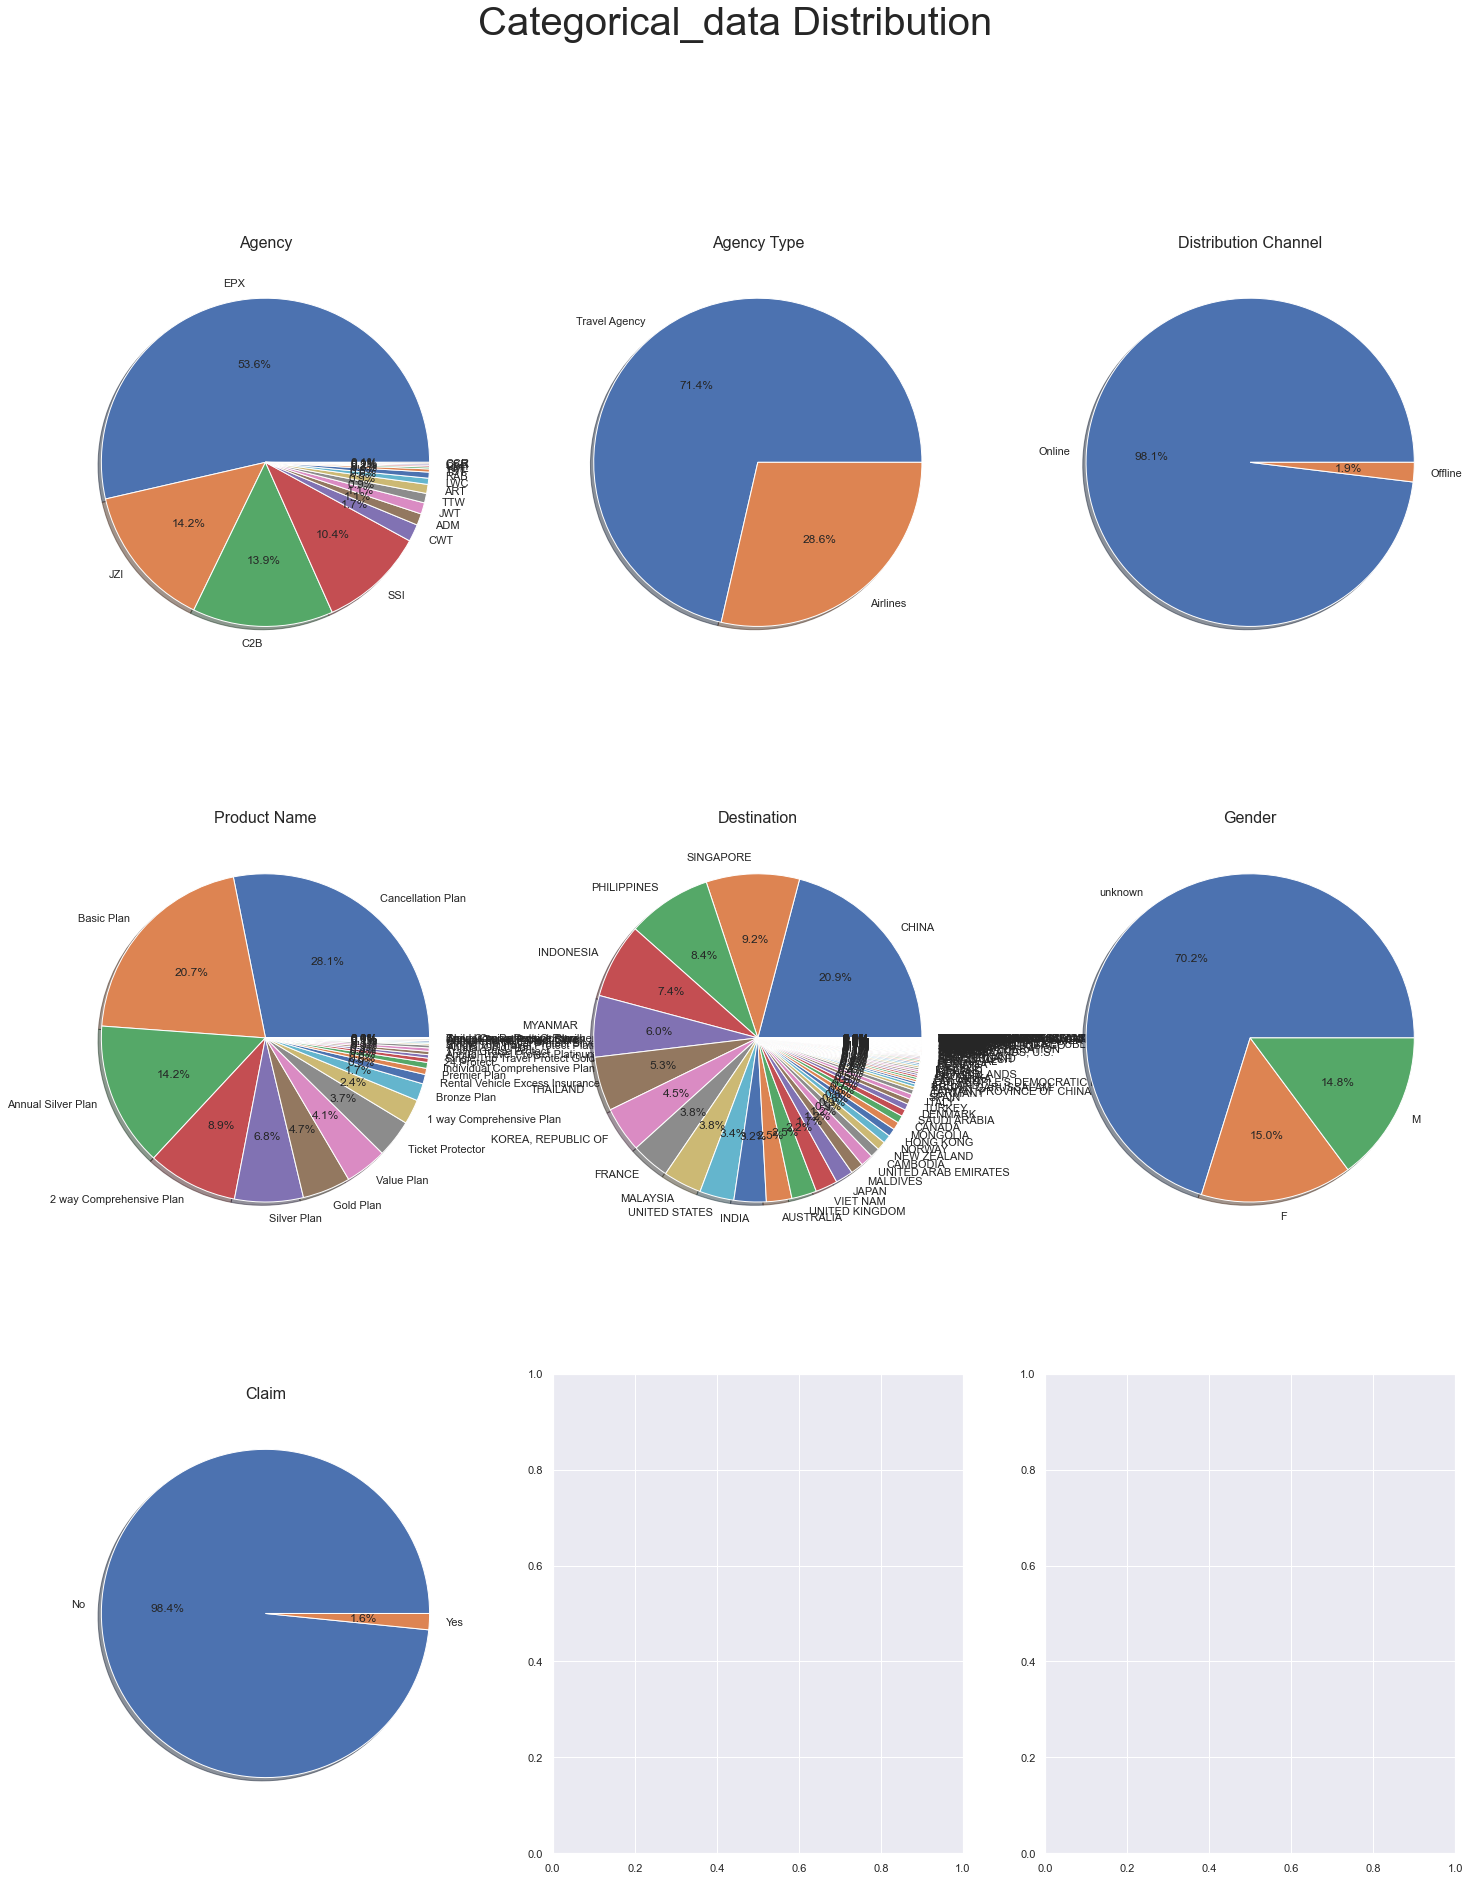

In [2585]:
import random
import seaborn as sns
sns.set()
color_random = sns.color_palette()

#select categoricsl data
#categorical_data = df.select_dtypes(include = 'object').dropna()

rows = len(categorical.columns)//3 + np.where(len(categorical.columns)%3 > 0,1,0)
columns= 3

fig, axes = plt.subplots(rows, columns, figsize=(25, 30))
fig.suptitle('Categorical_data Distribution', size=40)

for i in range(1,rows*columns+1):           
    ax=plt.subplot(rows, 3, i)
    if len(categorical.columns) >= i :
       ax.pie(x=categorical[categorical.columns[i-1]].value_counts(),labels= categorical[categorical.columns[i-1]].unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
       plt.title(f'{categorical.columns[i-1]}',size=16,pad=10)
    else:
          break

***Explain: <br>
     - claim (target): imbalance 'yes', 'No' <br>
     - High Variance : Agency, Product Name, Destination. <br>
     - Low variance 'Agenct Type, Distribution Channel, Gender***

### Numerical Attributes Distribution

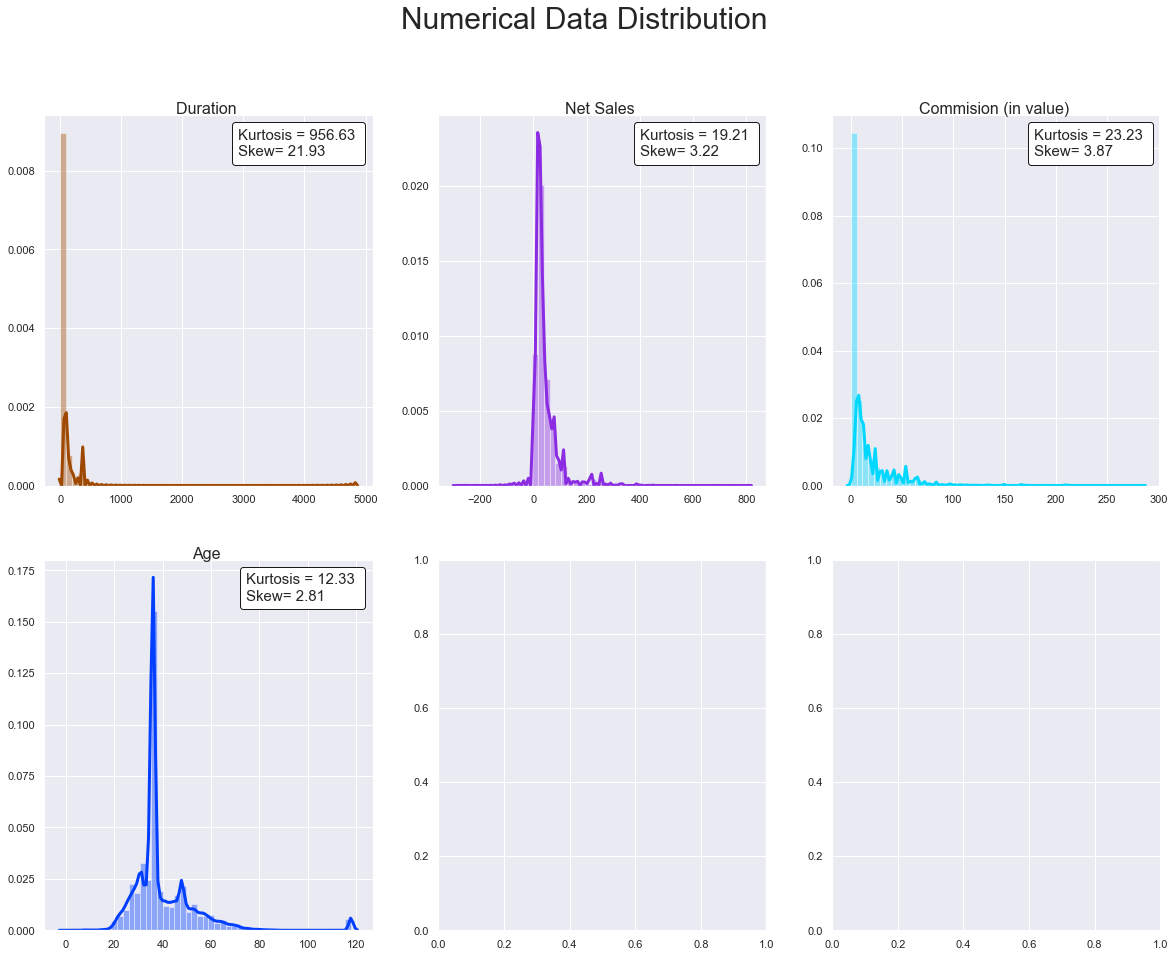

In [2586]:
import random
import seaborn as sns
import numpy as np
from matplotlib.offsetbox import AnchoredText
from scipy.stats import kurtosis, skew
sns.set()
color_random = sns.color_palette("bright",10)

#select numerical data
#numerical_data = df.select_dtypes(include = 'number')


rows = len(numerical.columns)//3 + np.where(len(numerical.columns)%3 > 0, 1,0)
columns= 3

fig, axes = plt.subplots(rows, columns, figsize=(20, 15))
fig.suptitle('Numerical Data Distribution', size=30)

for i in range(1,rows*columns+1):
    ax=plt.subplot(rows, 3, i)
    if len(numerical.columns) >= i :
        plt.title(f'{numerical.columns[i-1]} ',size=16,pad=1)
        sns.distplot(
                     numerical[numerical.columns[i-1]], 
                     hist = True, kde = True,axlabel = False,
                     kde_kws = {'linewidth': 3},
                     label = numerical.columns,
                     color = random.choice(color_random)
                     )
        _kurtosis_ = round(kurtosis(numerical[numerical.columns[i-1]]),2)
        _skew_ = round(skew(numerical[numerical.columns[i-1]]),2)
        at = AnchoredText(
                           f"Kurtosis = {_kurtosis_} \nSkew= {_skew_}",
                           prop=dict(size=15), frameon=True,loc='upper right',
                          )
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
    else:
        break

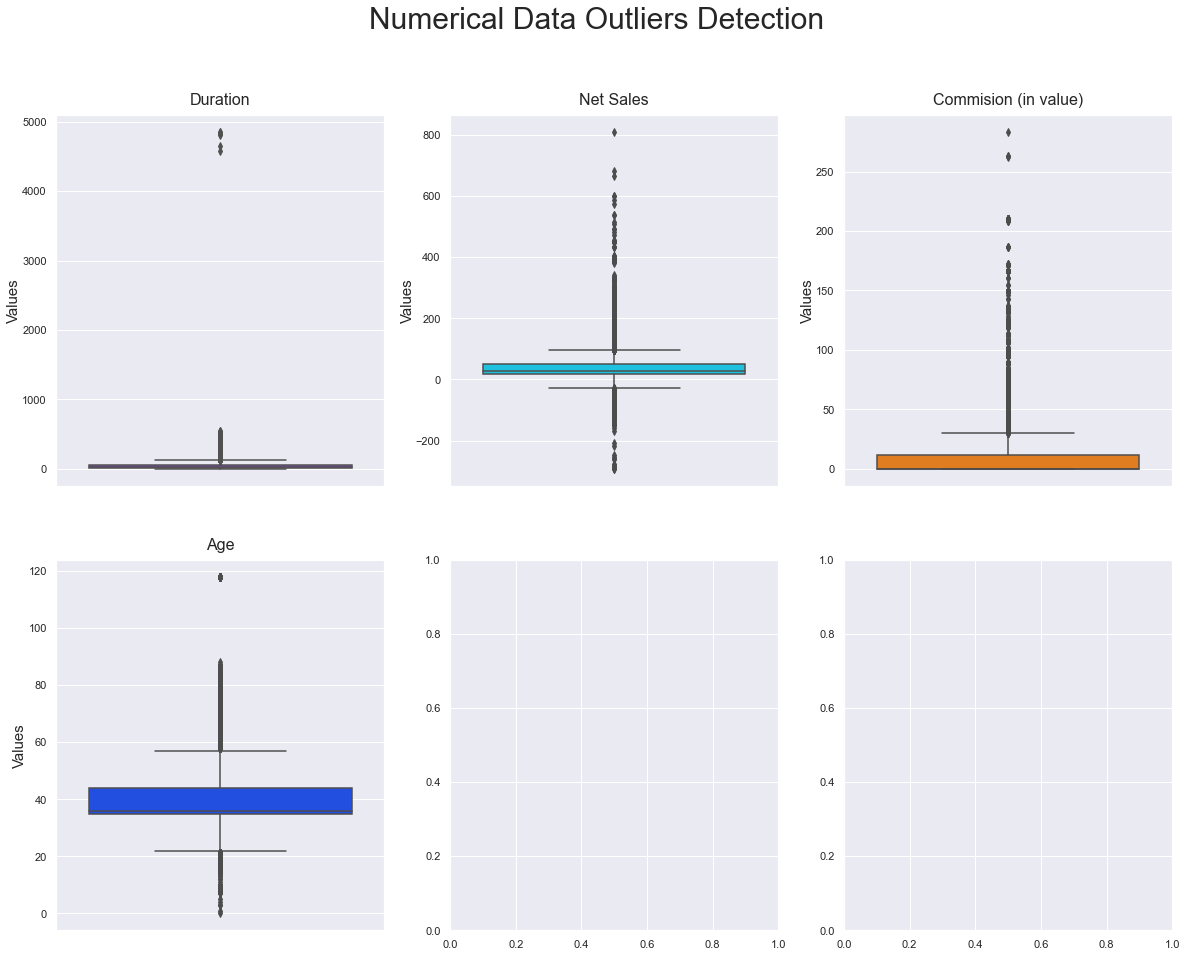

In [2587]:
import random
import seaborn as sns
sns.set()
color_random = sns.color_palette("bright",10)

#select numerical data
#numerical_data = df.select_dtypes(include = 'number')


rows = len(numerical.columns)//3 + np.where(len(numerical.columns)%3 > 0,1,0)
columns= 3

fig, axes = plt.subplots(rows, columns, figsize=(20, 15))
fig.suptitle('Numerical Data Outliers Detection', size=30)

for i in range(1,rows*columns+1):
    ax=plt.subplot(rows, 3, i)
    if len(numerical.columns) >= i :
         sns.boxplot(
                      numerical[numerical.columns[i-1]],
                      data=numerical, 
                      orient = 'v',
                      color = random.choice(color_random)
                     )
         plt.ylabel('Values',size=15,labelpad=1)
         plt.title(f'{numerical.columns[i-1]}',size=16,pad=10)
    else:
            break
        

In [2588]:
numerical.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Duration,28467.0,52.031616,102.182076,-1.00,10.0,24.0,56.00,4857.0
Net Sales,28467.0,42.394840,50.463972,-291.75,19.0,29.0,50.00,810.0
Commision (in value),28467.0,10.325322,20.178261,0.00,0.0,0.0,11.88,283.5
Age,28467.0,40.041170,13.717879,0.00,35.0,36.0,44.00,118.0


***Explain: <br>
     - Duration - Skew <br>
     - Net Sales,Age - contain outliers
     - Commision (in value) - sparse data (50% zeros)***

### View Correlation Numerical Attributes - target

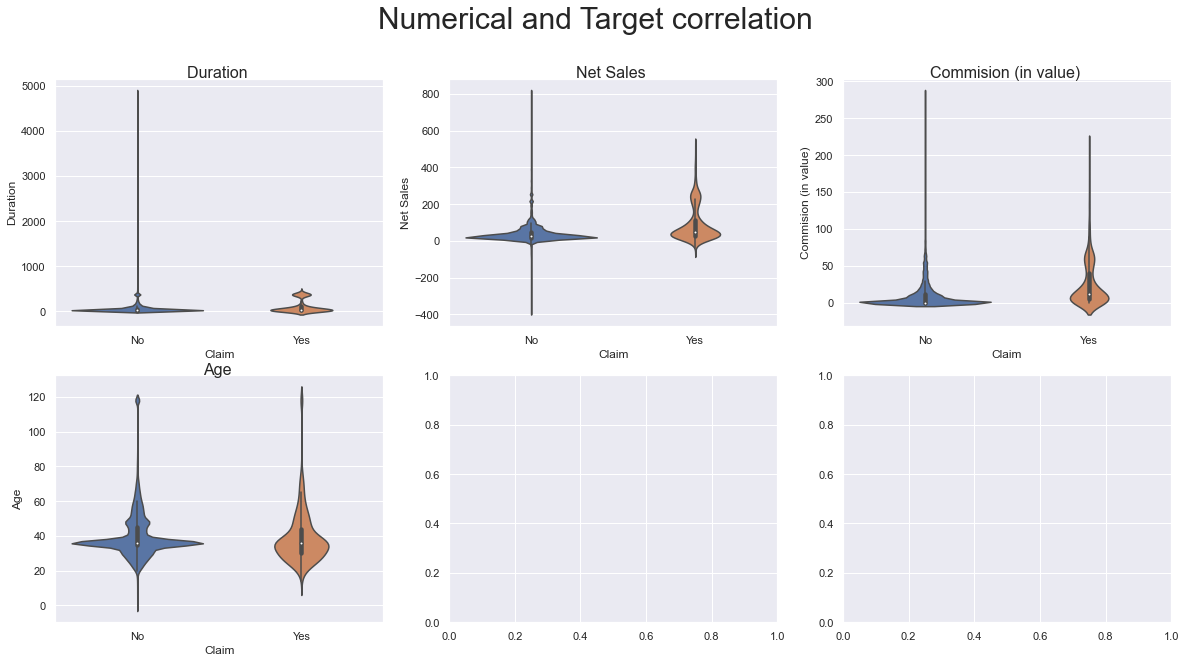

In [2544]:
rows = len(numerical.columns)//3 + np.where(len(numerical.columns)%3 > 0, 1,0)
columns= 3

fig, axes = plt.subplots(rows, columns, figsize=(20, 10))
fig.suptitle('Numerical and Target correlation', size=30)

for i in range(1,rows*columns+1):
    ax=plt.subplot(rows, 3, i)
    if len(numerical.columns) >= i :
        plt.title(f'{numerical.columns[i-1]} ',size=16,pad=1)
        sns.violinplot(x= df.Claim, y= numerical.iloc[:,i-1])
       
    else:
        break

### Statistic Correlation Numerical Attributes - target (Anova)

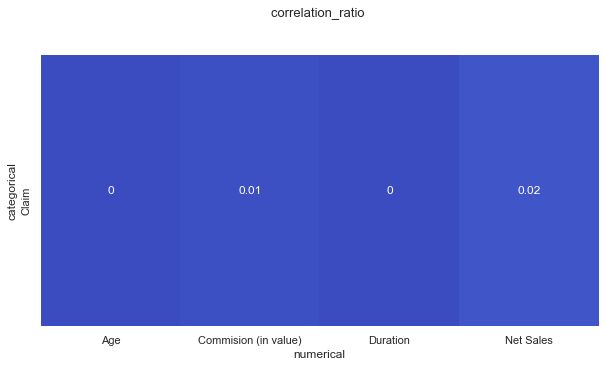

In [2591]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

numerical = df.select_dtypes('number')
categorical = df.Claim


def correlation_ratio(categories, measurements):
    """
    Calculates the Correlation Ratio (sometimes marked by the greek
    letter Eta) for categorical-continuous association.
    Answers the question - given a continuous value of a measurement,
    is it possible to know which category is it
    associated with?
    Value is in the range [0,1], where 0 means a category cannot be
    determined by a continuous measurement, and 1 means
    a category can be determined with absolute certainty.

    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio

    :param categories: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param measurements: list / NumPy ndarray / Pandas Series
        A sequence of continuous measurements
    :return: float
        in the range of [0,1]
    """
    categories = categories.array
    measurements = measurements.array
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(
        y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta



feature1 = []
feature2 = []
correlation_ratio_list = [] 

#for category in categorical.columns.to_list():
for number in numerical.columns.to_list():
        feature1.append('Claim')
        feature2.append(number) 
        result = correlation_ratio(categorical, numerical.loc[:,number])         
        correlation_ratio_list.append(result)       
        

# create correlation table
correlation_ratio_table = pd.DataFrame(zip(feature1,feature2,correlation_ratio_list)).rename(columns={0:'categorical',1:'numerical',2:'correlation_ratio'})
#correlation_ratio_table = correlation_ratio_table.loc[(correlation_ratio_table.correlation_ratio >=0.4),:]

#show heat map (above 0.75 strong relation)
plt.figure(figsize=(10,5))
plt.title('correlation_ratio ', y = 1.12, size=13, loc="center")
sns.heatmap(pd.crosstab(correlation_ratio_table.categorical,
            correlation_ratio_table.numerical,
            values=round(correlation_ratio_table['correlation_ratio'],2),
            aggfunc= 'sum'),
            cmap="coolwarm", annot=True, cbar=False,vmin = 0, vmax = 1,center = 0.5)
plt.show()

***Explain:
    No correlation Between 'Claim'  and Numerical Attributes***

### View Correlation Categorical Attributes - target

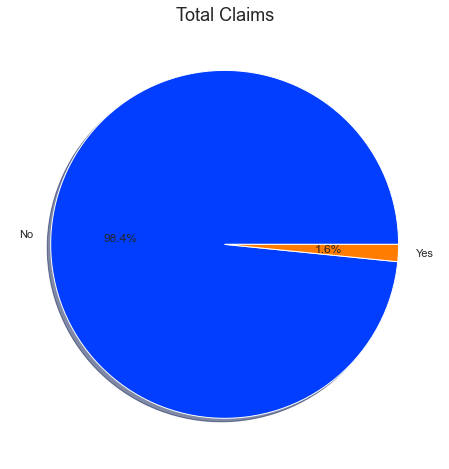

In [2592]:
plt.figure(figsize=(10,8))
plt.pie(x=df.Claim.value_counts(),labels= df.Claim.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Total Claims',size=18)
plt.show()

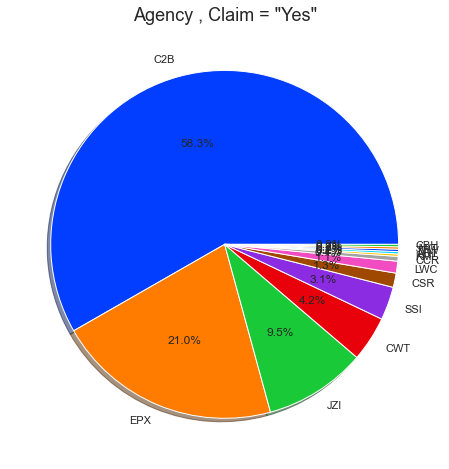

In [2593]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Agency']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Agency , Claim = "Yes"',size=18)
plt.show()

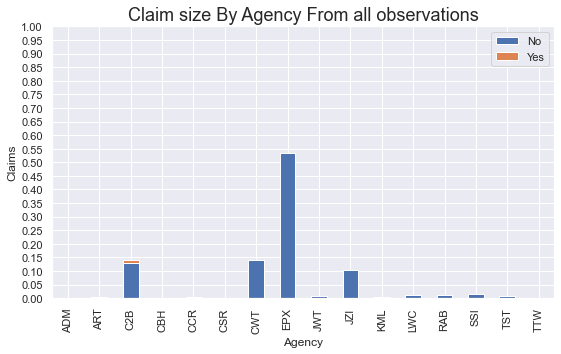

In [2594]:
a = df.groupby(['Agency','Claim']).size()/len(df)
my_plot = a.unstack().plot(kind='bar',stacked=True,title="Claims By Agency From All observations",figsize=(9, 5))
my_plot.set_xlabel("Agency")
my_plot.set_ylabel("Claims")
my_plot.legend(["No","Yes"], loc='upper right')

plt.title('Claim size By Agency From all observations',size=18)
plt.yticks(ticks = np.arange(0,1.05,0.05))
plt.show()

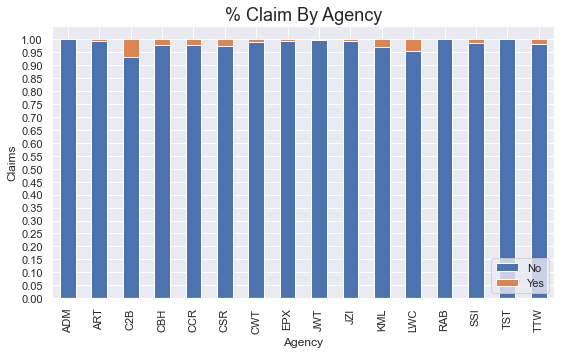

In [2595]:
a =  df.groupby(['Agency','Claim']).size()/df.groupby(['Agency']).size()
my_plot = a.unstack().plot(kind='bar',stacked=True,title="Claims By Agency From All observations",figsize=(9, 5))
my_plot.set_xlabel("Agency")
my_plot.set_ylabel("Claims")
my_plot.legend(["No","Yes"], loc='lower right')
plt.yticks(ticks = np.arange(0,1.05,0.05))
plt.title('% Claim By Agency',size=18)
plt.show()

***Explain:<br>
    Most of the 'Yes' Claims ~60% received from CWT agency.<br>
    'CWT','C2B' are ~30% from total observations. <br>
    They contain ~80% from total 'Yes' claims***

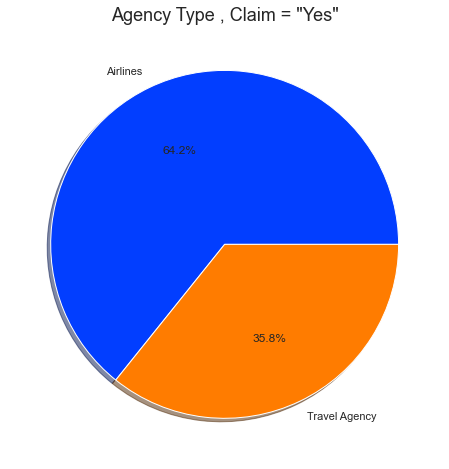

In [2596]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Agency Type']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Agency Type , Claim = "Yes"',size=18)
plt.show()

***Explain: <br>
   Most of the observations are from Travel Agency ~70% and most of 'yes claims from Travel agency ~65%. <br>
   we can claim it isn't important predictor.***

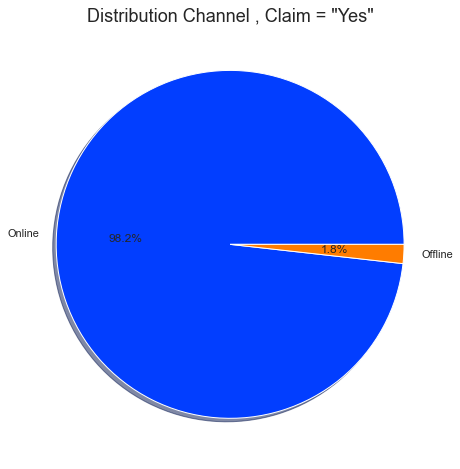

In [2597]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Distribution Channel']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Distribution Channel , Claim = "Yes"',size=18)
plt.show()

***Explain: <br>
   Most of the observations are from online category and most of 'yes claims from online <br>
   we can claim it isn't important predictor.***

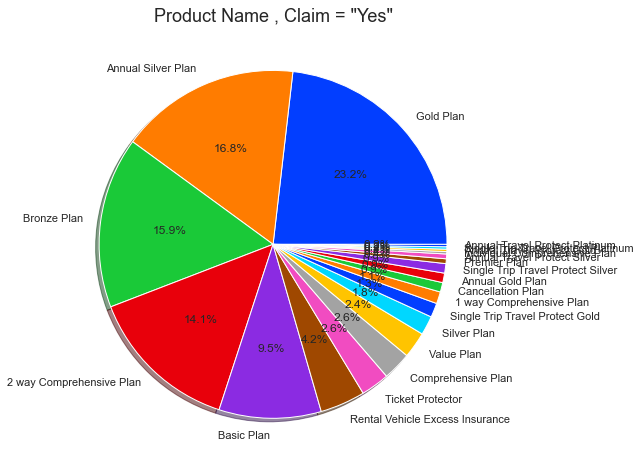

In [2598]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Product Name']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Product Name , Claim = "Yes"',size=18)
plt.show()

***Explain: <br>
   6 Products : are ~85% from all claims and ~50% from all observations. <br>
   most important: <br>
   rental vehicle plan, annual silver plan, 2 way comprehensive plan,silver plan, bronze plan, annual gold plan*** 

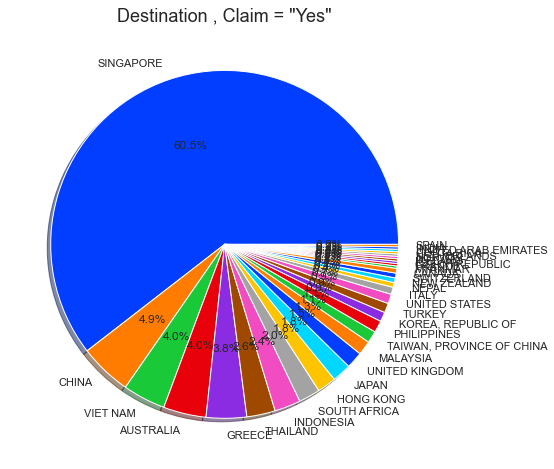

In [2599]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Destination']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Destination , Claim = "Yes"',size=18)
plt.show()

***Explain:
   ~60% from all claims are from Thailand destination and most of claims from Asia destination.*** 

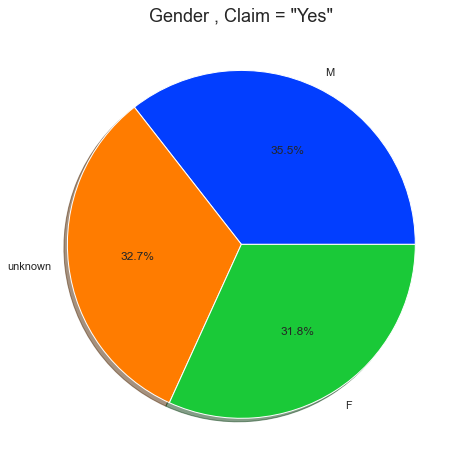

In [2600]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Gender']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Gender , Claim = "Yes"',size=18)
plt.show()

***Explains: There is no meaning for gender . claims from female and male are in same proportions***

### Statistic Correlation Categorical - Target (Chi Square)

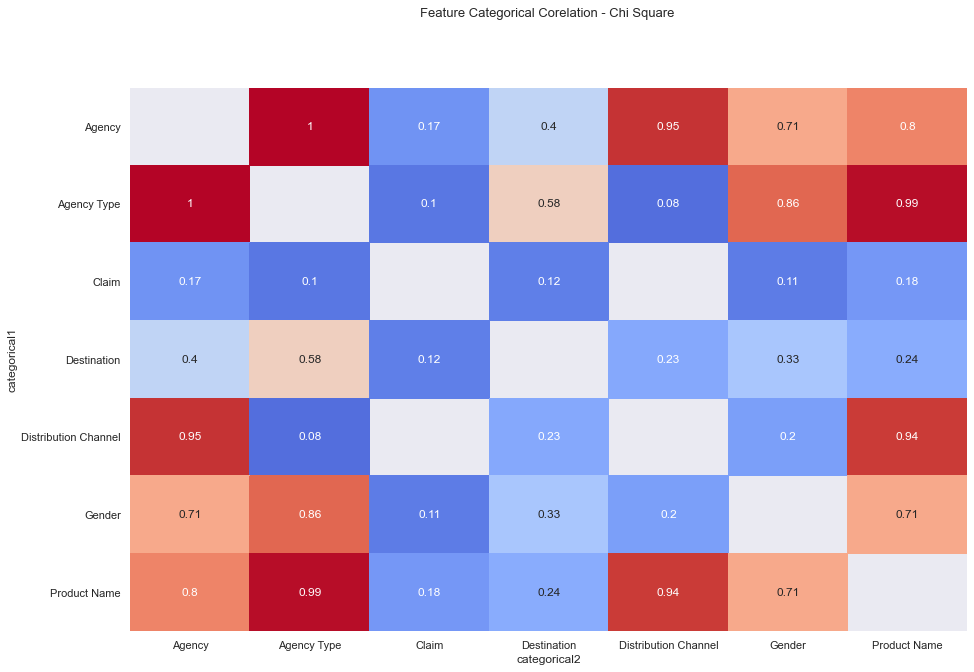

In [2601]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

categorical_data = df.select_dtypes('object')


# calculate correlation
feature1 = []
feature2 = []
cramer = [] 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

x=0
while True:
     y=0
     while y < len(categorical_data.columns) :
          feature1.append(categorical_data.iloc[:,x].name)
          feature2.append(categorical_data.iloc[:,y].name) 
          result = cramers_v(categorical_data.iloc[:,x], categorical_data.iloc[:,y])         
          cramer.append(result)    
          y+=1
     x+=1
     if x == len(categorical_data.columns) :
        break
  

# create correlation table
cramer_table = pd.DataFrame(zip(feature1,feature2,cramer)).rename(columns={0:'categorical1',1:'categorical2',2:'Cramer correlation'})


#show heat map (above 0.75 strong relation)
cramer_table = cramer_table.loc[(cramer_table['Cramer correlation'] >=0.01) & (cramer_table.categorical1 != cramer_table.categorical2),:]
plt.figure(figsize=(15,10))
plt.title('Feature Categorical Corelation - Chi Square ', y = 1.12, size=13, loc="center")
sns.heatmap(pd.crosstab(cramer_table.categorical1,
            cramer_table.categorical2,
            values=round(cramer_table['Cramer correlation'],2),
            aggfunc= 'sum'),
            cmap="coolwarm", annot=True, cbar=False,vmin = 0, vmax = 1,center = 0.5)
plt.show()


***Explain: Chi Square didn't find any correlation between claim and categorical data***

***Summary: <BR>
    we can identify correlation between 'Agency', 'Product Name', 'Destination' to 'Claim'. <BR>
    In addition we need to create new feature is name continent***

### Feature Engineering

 * 1. **Add new Features**
 * 2. **Data Transformation**
 * 3. **Create new features** - not added

1. **Add new Features**

In [2602]:
continents = pd.read_csv(r'C:\\Users\Home\Documents\idan\Kaggle\Binary_classification\Insuarance_claim\Dataset\continents_countries.csv')  
df = pd.merge(left = df,right =continents,how='left',left_on= 'Destination',right_on='Country')
df = df.drop(columns='Country')

# test
test = pd.merge(left = test,right =continents,how='left',left_on= 'Destination',right_on='Country')
test = test.drop(columns='Country')

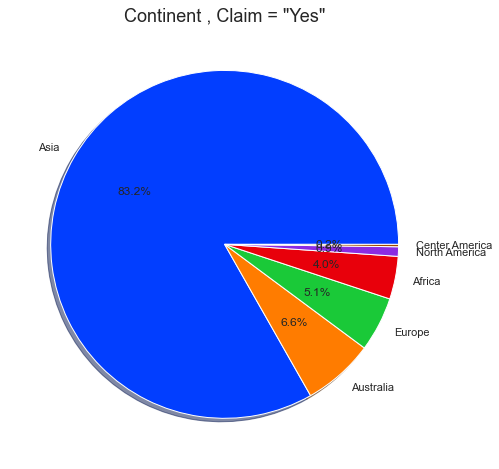

In [2603]:
plt.figure(figsize=(10,8))
categorical = df.loc[df.Claim == 'Yes','Continent']
plt.pie(x=categorical.value_counts(),labels= categorical.unique(),colors=color_random,autopct='%1.1f%%', shadow=True)
plt.title('Continent , Claim = "Yes"',size=18)
plt.show()

***Explain: ~85% from all claims from Asia***

 * **2. Data Transformation**

Explain : categories with less than 1% merge to 'Other' group

In [2604]:
############ categories with less than 1% merge to  to 'Other' group  #########################
# train
categorical_table_transform  = {}
for column in df.select_dtypes('object').columns:
    categorical_transform =(df.groupby(column).size()/len(df[column].dropna())).reset_index().rename(columns={column:'category',0:'weight'})
    if categorical_transform.weight.min() < 0.01 :
       categorical_transform = categorical_transform[categorical_transform.weight <=0.01]
       df[column] = df[column].apply(lambda x: 'other' if x in categorical_transform['category'].tolist() else x)
       categorical_table_transform.update({column: df[column].unique().tolist()})
    else: 
        pass
  
# test
for column in categorical_table_transform.keys():
   test[column] = test[column].apply(lambda x: x if x in (categorical_table_transform[column]) else 'other')

### Scale & Encode

In [2605]:
X_train_categorical = df.select_dtypes('object').drop(columns='Claim')
X_test_categorical = test.select_dtypes('object').drop(columns='Claim')

**Using mapper**

In [2606]:
mapper = DataFrameMapper([(['Duration'], PowerTransformer(method='yeo-johnson'))
                          ,(['Net Sales'], QuantileTransformer(output_distribution='normal'))
                          ,(['Commision (in value)'], KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'))
                          ,(['Age'],PowerTransformer(method='yeo-johnson'))
                          ,(['Claim'],LabelEncoder())]
                          ,df_out = True, input_df=True)

#train
mapping_dataset = mapper.fit_transform(df)

#test
test_numerical = mapper.transform(test.loc[:,test.columns.isin(mapper.transformed_names_)])

**Frequency Encoding**

In [2607]:
class  Frequency_Encoding :
        
     def __init__ (self):
       pass

     def fit_transform (train):
         encoding_table = {}
         dataset = train.select_dtypes('object')   
         for attribute in dataset.columns:
             frequency_encoder =  (dataset.groupby(attribute).size()/len(dataset)).to_dict()
             dataset[attribute] =  dataset[attribute].map(frequency_encoder) 
             encoding_table.update({attribute:pd.DataFrame.from_dict(frequency_encoder, orient='index', columns=['Encode']).reset_index().rename(columns= {'index':'category'})})
         output = dataset.copy()
         return output , encoding_table 
        
     def transform (encoding_table,test):
         output = {}
         categorical = test.select_dtypes('object')
         for i in encoding_table.keys():
             merge = pd.merge(left=categorical[i],
                              right = encoding_table[i], how='left',
                              left_on= i,
                              right_on='category')
             output.update({i: merge['Encode'].reset_index(drop=True)})        
         return  pd.DataFrame(output)
    
     def inverse (encoding_table,df) :  
          output = {}  
          categorical = df.copy()
          for i in encoding_table.keys() :
              merge = pd.merge(left=categorical[i],
                                right = encoding_table[i], how='left',
                                left_on= i,
                                right_on='Encode')
              output.update({i: merge['category'].reset_index(drop=True)})
              categorical[i] =  output[i] 
              categorical[i] = categorical[i].fillna('other')
              categorical[i] = categorical[i].apply(lambda x: 'other' if x ==None else x) 
          return  categorical #pd.DataFrame(self.output) 

In [2608]:
X_train_categorical['Commision (in value)'] = mapping_dataset['Commision (in value)'].astype('object')
mapping_dataset = mapping_dataset.drop(columns='Commision (in value)')
X_train_categorical, encoding_table =Frequency_Encoding.fit_transform(X_train_categorical)

# test
X_test_categorical['Commision (in value)'] = test_numerical['Commision (in value)'].astype('object')
test_numerical = test_numerical.drop(columns='Commision (in value)')
X_test_categorical = Frequency_Encoding.transform(encoding_table,X_test_categorical)
#inverse = Frequency_Encoding.inverse(encoding_table,train_categorical)

**merge encoder + mapper**

In [2609]:
df = pd.concat([mapping_dataset,X_train_categorical],axis=1)
test = pd.concat([test_numerical,X_test_categorical],axis=1)

### Evaluate Model by PCA & RandomForest

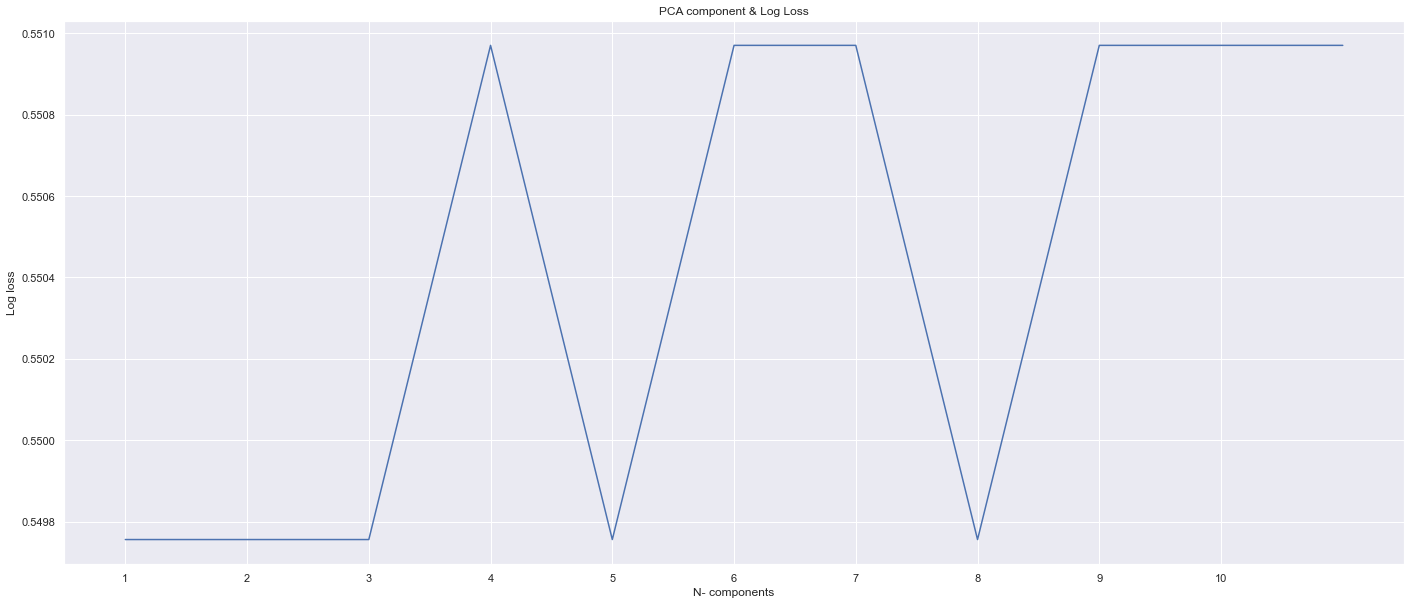

In [2610]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score ,log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

df = df.dropna()
X = df.drop(columns='Claim')
y = df.Claim

evaluate= pd.DataFrame({'component':[],'F1':[],'Log_Loss':[]})
for i in range(1,len(X.columns)+1):
    skf = StratifiedKFold(n_splits=5)
    LGB = LGBMClassifier(max_depth=3) #RandomForestClassifier(n_estimators=100,max_depth=10, random_state=0)
    pipe =  Pipeline ([('PCA',PCA(n_components =i)),('classifier',LGB)])
    scorer = make_scorer(f1_score)#f1_score)
    f_score = cross_val_score(pipe, X, y, cv=skf, scoring=scorer).mean()
    scorer = make_scorer(log_loss)
    LogLoss = cross_val_score(pipe, X, y, cv=skf, scoring=scorer).mean()
    evaluate = evaluate.append({'component':i,'F1':f_score,'Log_Loss':LogLoss},ignore_index=True)
    
#chart
plt.title('PCA component & Log Loss')
plt.plot(evaluate.component,evaluate.Log_Loss)

plt.xlabel('N- components')
plt.ylabel('Log loss')
plt.xticks(ticks=range(1,11))
plt.show()

In [2611]:
evaluate

,component,F1,Log_Loss
0,1.0,0.0,0.549756
1,2.0,0.0,0.549756
2,3.0,0.0,0.549756
3,4.0,0.0,0.550970
4,5.0,0.0,0.549756
5,6.0,0.0,0.550970
6,7.0,0.0,0.550970
7,8.0,0.0,0.549756
8,9.0,0.0,0.550970
9,10.0,0.0,0.550970


***Explain: We can see model didn't learn anything  F1 = 0, no matter components number***

### Feature Importance

  * 1 Bootstrap resampling
  * 2. View important features according each method: 
         * 2.A Filter Methods:
               * 2.A.1 mutual_info_regression
               * 2.A.2 Pearson
               * 2.A.3 spearman
         * 2.B Wrapper Methods :
               * 2.B.1 LassoCV
               * 2.B.2 Boruta_rf
               * 2.B.3 Linear_Step_Wise (bi directional)
               * 2.B.4 Forward selection - Knn regressor
               * 2.B.5 LightGBM 
               * 2.B.6 BayesianRidge
  * 3. Vote and choose the most for the most important features

**1. Bootstraping**

For saving time we will use resampling. <br>
we will pick 1000 observations for 10 times. <br>
afterwards will calculate feature importance score

In [2612]:
df = pd.concat([X,y],axis=1)

**2.A.1 mutual_info_regression**

In [2613]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')

mutual_info= pd.DataFrame({'feature':[],'importance':[]})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    f_selector.fit_transform(X_train, y_train)
    table = pd.DataFrame(zip(X_train.columns.to_list(),f_selector.scores_.tolist()),columns=['feature','importance'])
    mutual_info= mutual_info.append(table)
    
mutual_info = mutual_info.groupby('feature').mean().sort_values(by='importance',ascending=False).reset_index()
mutual_info =mutual_info.loc[mutual_info.importance >= mutual_info.importance.quantile(0.50),'feature'].to_frame('mutual_info')

**1.A.2 Pearson**

In [2614]:
pearson= pd.DataFrame({'feature':[],'corr (r)':[]})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    table = pd.concat([X_train,y_train.to_frame(name='target')],axis=1).corr('pearson')['target'].reset_index().rename(columns={'index':'feature','target':'corr (r)'})
    pearson= pearson.append(table)
    
pearson = pearson.groupby('feature').mean().sort_values(by='corr (r)',ascending=False).reset_index()
pearson = pearson.loc[(abs(pearson['corr (r)'])>=0.4) & (pearson.feature !='target'),'feature'].to_list()
pearson = pd.Series(pearson).to_frame('pearson')

In [2615]:
pearson

,pearson


**1.A.3 Spearman**

In [2616]:
spearman= pd.DataFrame({'feature':[],'corr (r)':[]})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    table = pd.concat([X_train,y_train.to_frame(name='target')],axis=1).corr('spearman')['target'].reset_index().rename(columns={'index':'feature','target':'corr (r)'})
    spearman= spearman.append(table)
    
spearman = spearman.groupby('feature').mean().sort_values(by='corr (r)',ascending=False).reset_index()
spearman = spearman.loc[(abs(spearman['corr (r)'])>=0.40) & (spearman.feature !='target'),'feature'].to_list()
spearman = pd.Series(spearman).to_frame('spearman')

In [2617]:
spearman

,spearman


**1.B.1 LassoCV**

In [2618]:
'''
 ##################
 Lasso GridSearch - Hyper Parameter Tune 
 ##################
'''

lasso = GridSearchCV(estimator = LinearSVC()
                    ,param_grid= {'penalty' :['l2'], 'C':[0.01,0.1]}
                    ,scoring = 'r2'
                    ,cv= 5
                    ,refit= True)

lasso.fit(X_train,y_train)
print('hyperparameter:',lasso.best_params_)

'''
 ##################
 Lasso Model 
 ##################
'''
from sklearn.linear_model import LassoCV

lasso= pd.DataFrame({'feature':[],'importance':[]})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    regressor = LassoCV(alphas=[0.01])
    regressor.fit(X_train,y_train)
    table = pd.DataFrame(zip(X_train.columns.to_list(),abs(regressor.coef_).tolist()),columns=['feature','importance']).sort_values(by='importance',ascending=False).reset_index(drop=True)
    lasso= lasso.append(table)

'''    
##################
 Lasso Results 
##################
'''
    
lasso = pd.DataFrame(zip(X_train.columns.to_list(),abs(regressor.coef_).tolist()),columns=['feature','importance']).sort_values(by='importance',ascending=False).reset_index(drop=True)
lasso = lasso.loc[lasso.importance > 0,'feature'].to_frame('lasso')

hyperparameter: {'C': 0.01, 'penalty': 'l2'}


**1.B.2 Boruta random forest**

In [2619]:
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

###initialize Boruta
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100) # number of trials to perform


Boruta_RF= pd.DataFrame({'feature':[]})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    ### fit Boruta (it accepts np.array, not pd.DataFrame)
    boruta.fit(np.array(X_train), np.array(y_train))
    # score
    green_area = X_train.columns[boruta.support_].to_list()
    blue_area = X_train.columns[boruta.support_weak_].to_list()
    table = pd.Series(green_area + blue_area).to_frame('feature')
    Boruta_RF= Boruta_RF.append(table)




Boruta_RF = Boruta_RF.value_counts().reset_index().rename(columns={0:'importance'})
Boruta_RF = Boruta_RF.loc[:,'feature'].to_frame('Boruta_RF')

**1.B.3 Linear_Step_Wise (bi directional)**

In [2620]:
 # Sequential Forward Selection    
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression   
linear = LinearRegression()

step_wise = pd.DataFrame({})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    sfs = SFS(linear, 
                  k_features=(1,len(X_train.columns)), 
                  forward=True, 
                  floating=True, 
                  scoring='r2',
                  cv=5,
                  n_jobs=-1)
    sfs.fit(X_train, y_train)
    table = pd.Series([i for i in sfs.k_feature_names_]).to_frame('Linear_Step_Wise')
    step_wise = step_wise.append(table)
    
step_wise = step_wise.value_counts().reset_index().rename(columns={0:'importance'})
step_wise = step_wise['Linear_Step_Wise']

**1.B.4 Forward selection by Knn regressor**

In [2621]:
 # Sequential Forward Selection    
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsRegressor     
knn = KNeighborsRegressor(n_neighbors=4)

FS_KNN = pd.DataFrame({})
for iterator in range (1,10):
    sample = df.sample(n=1000, replace=False, random_state=1)
    X_train = sample.drop(columns='Claim')
    y_train = sample.Claim
    sfs = SFS(knn, 
                  k_features=(1,len(X_train.columns)), 
                  forward=True, 
                  floating=False, 
                  scoring='r2',
                  cv=4,
                  n_jobs=-1)
    sfs.fit(X_train, y_train)
    table  = pd.Series([i for i in sfs.k_feature_names_]).to_frame('FS_KNN')
    FS_KNN = FS_KNN.append(table)

FS_KNN = FS_KNN.value_counts().reset_index().rename(columns={0:'importance'})
FS_KNN = FS_KNN['FS_KNN']

**1.B.5 LightGBM**

In [2622]:
import lightgbm as lgb
model = lgb.LGBMRegressor(boosting_type='dart',objective='RMSE',random_state=1,reg_alpha=1,learning_rate= 0.01,subsample= 0.5)

LGB = pd.DataFrame({})
for iterator in range (1,10):
     sample = df.sample(n=1000, replace=False, random_state=1)
     X_train = sample.drop(columns='Claim')
     y_train = sample.Claim
     model.fit(X_train.values,y_train)
     table = pd.DataFrame(zip(X_train.columns.to_list(),model.feature_importances_.tolist()),columns=['feature','importance'])
     LGB = LGB.append(table)

LGB = LGB.groupby('feature')['importance'].mean().reset_index()
LGB = LGB.loc[LGB.importance>0,'feature'].to_frame('LGB')

**1.B.6 BayesianRidge**

In [2623]:
# BayesianRidge for feature importance
from sklearn import linear_model
model = linear_model.BayesianRidge()

BayesianRidge = pd.DataFrame({})

for iterator in range (1,10):
     sample = df.sample(n=1000, replace=False, random_state=1)
     X_train = sample.drop(columns='Claim')
     y_train = sample.Claim
     model.fit(X_train.values, y_train)
     table = pd.DataFrame(zip(X_train.columns.to_list(),abs(model.coef_).tolist()),columns=['feature','importance'])
     BayesianRidge = BayesianRidge.append(table)
    
BayesianRidge = BayesianRidge.groupby('feature')['importance'].mean().reset_index()
BayesianRidge = BayesianRidge.loc[BayesianRidge.importance >=BayesianRidge.importance.quantile(0.75),'feature'].reset_index(drop=True).to_frame('BayesianRidge')

**Vote and choose the most for the most important features**

In [2624]:
Attributes = pd.Series(X_train.columns).to_frame('Attributes')
summary =  pd.merge (
                        left = pd.merge(
                                           left = pd.merge(  
                                                            left = pd.merge(
                                                                      left = pd.merge( 
                                                                                      left= pd.merge(
                                                                                                left= pd.merge(
                                                                                                                 left =  pd.merge(
                                                                                                                            left = pd.merge(Attributes,mutual_info,how='left',left_on='Attributes',right_on='mutual_info')
                                                                                                                           ,right = pearson,left_on='Attributes',right_on='pearson',how='left')
                                                                                                                 ,right = spearman,left_on='Attributes',right_on='spearman',how='left')
                                                                                               ,right= lasso, left_on='Attributes',right_on='lasso',how='left')
                                                                                      ,right= Boruta_RF, left_on='Attributes',right_on='Boruta_RF',how='left')
                                                                       ,right= Linear_Step_Wise, left_on='Attributes',right_on='Linear_Step_Wise',how='left')
                                                              ,right = FS_KNN, left_on='Attributes',right_on='FS_KNN',how='left')
                                          ,right =  LGB, left_on='Attributes',right_on='LGB',how='left')
                         ,right =  BayesianRidge, left_on='Attributes',right_on='BayesianRidge',how='left')
         

for column in summary.drop(columns = 'Attributes').columns:
    summary[column] = summary[column].apply(lambda x: 0 if pd.isnull(x)==True else 1)
    
summary['score'] = summary.sum(axis=1)
summary = summary.sort_values(by='score',ascending=False).reset_index(drop=True) 
display(summary)

,Attributes,mutual_info,pearson,spearman,lasso,Boruta_RF,Linear_Step_Wise,FS_KNN,LGB,BayesianRidge,score
0,Net Sales,0,0,0,1,1,1,0,1,0,4
1,Gender,1,0,0,0,0,1,0,1,1,4
2,Agency,1,0,0,0,0,1,0,1,0,3
3,Distribution Channel,1,0,0,0,0,1,1,0,0,3
4,Destination,1,0,0,0,0,0,0,1,1,3
5,Duration,0,0,0,0,0,0,0,1,0,1
6,Age,0,0,0,0,0,0,0,1,0,1
7,Agency Type,1,0,0,0,0,0,0,0,0,1
8,Product Name,1,0,0,0,0,0,0,0,0,1
9,Continent,0,0,0,0,0,0,0,0,1,1


***Explain: <br>
we can See the Attributes are weak the best attributes have score 4 out from 9 <br>
we will select attributes score 3-4 has the best features***

### Feature Selection

In [2625]:
selected_features = summary.loc[summary.score>=3,'Attributes'].to_list()
X = df.loc[:,df.columns.isin(selected_features)]
df = pd.concat([X,y],axis=1)

**save to csv**

In [2626]:
df.to_csv(r'C:\\Users\Home\Documents\idan\Kaggle\Binary_classification\Insuarance_claim\Dataset\df_ready_for_prediction.csv',index=False)

#  Make Prediction


Algoritms: <br>

  * Knn
  * RandomForest
  * XGBoost
  * LightGBM
  * AdaBoost
  * CatBoost

**read from csv**

In [2657]:
df =pd.read_csv(r'C:\\Users\Home\Documents\idan\Kaggle\Binary_classification\Insuarance_claim\Dataset\df_ready_for_prediction.csv')  

In [2658]:
X = df.drop(columns='Claim')
y= df.Claim

In [2629]:
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import  f1_score
from sklearn.metrics import log_loss as Log_Loss


Knn = KNeighborsClassifier(n_neighbors=5,weights='uniform')
RandomForest = RandomForestClassifier(min_samples_leaf=10)
XGBoost = XGBClassifier(max_depth =3)
LightGBM = LGBMClassifier(max_depth=3)
AdaBoost = AdaBoostClassifier()
CatBoost = CatBoostClassifier(silent=True)

classifiers = [Knn,RandomForest, XGBoost,LightGBM,AdaBoost,CatBoost]
classifiers_name = ['Knn','RandomForest', 'XGBoost','LightGBM','AdaBoost','CatBoost']
evaluate = pd.DataFrame({'Classifier':[],'F1_score':[],'Log_Loss':[]})

for index,clf in enumerate(classifiers):
   for sample in range(1,10):
        sample = df.sample(n=1000, replace=False, random_state=None)
        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30, random_state=None)
        X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)              
        estimator = clf
        estimator.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f_score = f1_score(y_test, y_pred, average='binary')
        log_loss = Log_Loss(y_test, y_pred)
        evaluate= evaluate.append({'Classifier':classifiers_name[index],'F1_score':f_score,'Log_Loss':log_loss},ignore_index=True)

# Evaluate Prediction

In [2630]:
evaluate.groupby('Classifier').mean()

,F1_score,Log_Loss
Classifier,,
AdaBoost,0.000000,0.551509
CatBoost,0.003141,0.559151
Knn,0.005521,0.565444
LightGBM,0.000000,0.550161
RandomForest,0.000000,0.550161
XGBoost,0.000000,0.550161


***Explain: <br>
    Raw Data contain very weak lerner which not allow models to learn. <br>
    Therefore, we need to add more relevant features***

### Try to improve accuracy by Over Sampling

In [2641]:
from imblearn.over_sampling import SMOTENC

df = df.dropna()
X_headers = df.drop(columns='Claim').columns.to_list()
X = df.drop(columns='Claim')
y = df.Claim
cat_col_index = [X.columns.get_loc(column) for column in X_train_categorical.loc[:,X_train_categorical.columns.isin(X.columns)]]

smote_nc = SMOTENC(categorical_features= cat_col_index, random_state=0,sampling_strategy='minority', k_neighbors=5)
smote_x_train, smote_y_train =  smote_nc.fit_resample(X, y)

df = pd.concat([smote_x_train,smote_y_train],axis=1)
print('dataset=',df.shape)
print(df.Claim.value_counts())

dataset= (56014, 6)
1    28007
0    28007
Name: Claim, dtype: int64


In [2643]:
classifiers = [Knn,RandomForest, XGBoost,LightGBM,AdaBoost,CatBoost]
classifiers_name = ['Knn','RandomForest', 'XGBoost','LightGBM','AdaBoost','CatBoost']
evaluate = pd.DataFrame({'Classifier':[],'F1_score':[],'Log_Loss':[]})

for index,clf in enumerate(classifiers):
   for sample in range(1,10):
        sample = df.sample(n=1000, replace=False, random_state=None)
        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30, random_state=None)
        X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)              
        estimator = clf
        estimator.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f_score = f1_score(y_test, y_pred, average='binary')
        log_loss = Log_Loss(y_test, y_pred)
        evaluate= evaluate.append({'Classifier':classifiers_name[index],'F1_score':f_score,'Log_Loss':log_loss},ignore_index=True)

In [2645]:
evaluate.groupby('Classifier').mean()

,F1_score,Log_Loss
Classifier,,
AdaBoost,0.724655,9.083915
CatBoost,0.891889,3.821025
Knn,0.879783,4.072667
LightGBM,0.798569,6.887278
RandomForest,0.873781,4.376174
XGBoost,0.854516,5.107406


***Explain: we see overfitting. model didn't learn anything***

### Try to improve accuracy by Under Sampling

In [2660]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

df = df.dropna()
X_headers = df.drop(columns='Claim').columns.to_list()
X = df.drop(columns='Claim')
y = df.Claim

renn = RepeatedEditedNearestNeighbours()
X_resampled, y_resampled = renn.fit_resample(X, y)

df = pd.concat([X_resampled,y_resampled],axis=1)
print('dataset=',df.shape)
print(df.Claim.value_counts())

In [2663]:
classifiers = [Knn,RandomForest, XGBoost,LightGBM,AdaBoost,CatBoost]
classifiers_name = ['Knn','RandomForest', 'XGBoost','LightGBM','AdaBoost','CatBoost']
evaluate = pd.DataFrame({'Classifier':[],'F1_score':[],'Log_Loss':[]})

for index,clf in enumerate(classifiers):
   for sample in range(1,10):
        sample = df.sample(n=1000, replace=False, random_state=None)
        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30, random_state=None)
        X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)              
        estimator = clf
        estimator.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f_score = f1_score(y_test, y_pred, average='binary')
        log_loss = Log_Loss(y_test, y_pred)
        evaluate= evaluate.append({'Classifier':classifiers_name[index],'F1_score':f_score,'Log_Loss':log_loss},ignore_index=True)

In [2664]:
evaluate.groupby('Classifier').mean()

,F1_score,Log_Loss
Classifier,,
AdaBoost,0.000000,0.553307
CatBoost,0.001599,0.558252
Knn,0.006867,0.569938
LightGBM,0.000000,0.550161
RandomForest,0.000000,0.550161
XGBoost,0.000000,0.550161


***Explain: we see overfitting. model didn't learn anything***

# Summary

Imbalance Target ~1.5% - Yes , ~98.5%- No . <br>
Not allow us to learn anything significant. <br>
My recommendation is to add more observations and/or add more attributes to explore